# Contact with the Lagrange Multiplier Method


In [1]:
import cmcrameri.cm as cmc
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element
from femsolver.compound import Compound, field

EPS = 1e-12

In [2]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


n = 30
mesh = Mesh.unit_square(n, n)
tri = element.Tri3()
op = Operator(mesh, tri)
material = Material(mu=1.0, lmbda=1.0)


n_nodes = mesh.coords.shape[0]
# contact nodes are those nodes on the left edge of the mesh
contact_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
n_lambda = contact_nodes.size


class Solution(Compound):
    u = field(shape=(n_nodes, 2))
    lm = field(shape=(n_lambda,))


sol = Solution()
sol

Solution(u=(961, 2), lm=(31,))

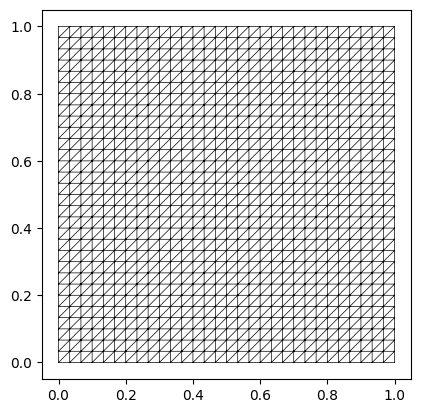

In [3]:
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")

## Constitutive Model for Linear Elasticity

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$

The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$


The femsolver provides a generic class `Operator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.


In [17]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@auto_vmap(eps=2)
def compute_stress(eps: Array, mat: Material) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mat.mu * eps + mat.lmbda * jnp.trace(eps) * I


@auto_vmap(grad_u=2)
def strain_energy(grad_u: Array, mat: Material) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mat)
    return 0.5 * jnp.sum(eps * sig)


def gap(x):
    # For a 45 degree slope, the gap is the signed distance to the line y = 0.5 + 5x -> y - 5x - 0.5 = 0
    return x[:, 1] - 5 * x[:, 0] - 0.5


def lagrangian(u: Array, lm: Array, contact_nodes: Array, mat: Material) -> Array:
    # u = u_flat.reshape(-1, n_dofs_per_node)
    strain_energy_density = strain_energy(op.grad(u), mat)
    g = gap((u + mesh.coords)[contact_nodes])
    contact_lm_term = jnp.sum(lm * g)

    return op.integrate(strain_energy_density) + contact_lm_term


dUdu = jax.grad(lagrangian, argnums=0)
dUdlm = jax.grad(lagrangian, argnums=1)


def jacobian(u: Array) -> Array:
    u, lm = Solution(u)
    return jnp.concatenate(
        [
            dUdu(u, lm, contact_nodes, material).flatten(),
            dUdlm(u, lm, contact_nodes, material),
        ]
    )


hessian = jax.jacfwd(jacobian)

### Lagrange Multiplier Method for Contact

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the contact penalty energy $\Psi_{contact}$.

Following a Lagrange multiplier approach, we define the total Lagrangian as:

$$
\mathcal{L}(u, \lambda) = \Psi_{elastic}(u) + \int_{\Gamma_c} \lambda g(u) dA
$$

Subject to the Kuhn-Tucker conditions

$$
g(u) \leq 0, \quad \lambda \geq 0, \quad \lambda g(u) = 0 \quad \text{on } \Gamma_c
$$


### Discrete Formulation

Assign one multiplier per contact node (x dof for each node):

$$
\mathcal{L}(u, \lambda) = \Psi_{elastic}(u) + \sum_{i=1}^{N_c} \lambda_i g_i(u_i) A_i
$$


In [18]:
def linear_solve(K: Array, rhs, active: Array, bc_dofs, bc_values) -> Array:
    jax.debug.print("Solving linear system with {n} dofs", n=K.shape[0])
    K = K.at[bc_dofs, :].set(0)
    K = K.at[:, bc_dofs].set(0)
    K = K.at[bc_dofs, bc_dofs].set(1.0)

    not_active = jnp.zeros(K.shape[0], dtype=bool)
    not_active = not_active.at[Solution.lm.slice.start :].set(~active)
    K = jnp.where(not_active[:, None], 0.0, K)
    K = jnp.where(not_active[None, :], 0.0, K)
    K = K.at[jnp.diag_indices_from(K)].set(jnp.where(not_active, 1.0, K.diagonal()))

    rhs = rhs.at[bc_dofs].set(bc_values)
    rhs = jnp.where(not_active, 0.0, rhs)

    return jnp.linalg.solve(K, rhs)


def solve_nr(
    sol: Solution,
    bc_dofs: Array,
    bc_values: Array,
    *,
    maxiter: int = 20,
    tol: float = 1e-6,
) -> Solution:
    u0 = sol.pack().at[bc_dofs].set(bc_values)
    res = jacobian(u0).at[bc_dofs].set(0.0)
    norm = jnp.linalg.norm(res)
    # active set of Lagrange multipliers
    active = jnp.ones(Solution.lm.shape[0], dtype=bool)

    def cond_fn(carry: tuple) -> bool:
        *_, norm, contact_converged, i = carry
        jax.debug.print(
            "Residual norm: {norm} [it: {it}, cc: {cc}]",
            norm=norm,
            it=i,
            cc=contact_converged,
        )
        return ((norm > tol) | (~contact_converged)) & (i < maxiter)

    def body_fn(carry: tuple) -> tuple:
        uflat, active, norm, contact_converged, i = carry

        delta = linear_solve(
            hessian(uflat),
            -jacobian(uflat),
            active,
            bc_dofs,
            bc_values - uflat[bc_dofs],
        )

        new = Solution(uflat + delta)
        g = gap((new.u + mesh.coords)[contact_nodes])
        new.lm = jnp.maximum(new.lm, 0.0)
        new_active = (new.lm > EPS) | (g > EPS)
        contact_converged = jnp.all(active == new_active)

        res = jacobian(new.pack()).at[bc_dofs].set(0.0)
        res = Solution(res)
        res.lm = jnp.where(new_active, res.lm, 0.0)
        norm = jnp.linalg.norm(res._data)

        return (new.pack(), new_active, norm, contact_converged, i + 1)

    uflat, active, norm, contact_converged, i = jax.lax.while_loop(
        cond_fn, body_fn, (u0, active, norm, False, 0)
    )
    return Solution(uflat)

## Solve system

We arrange the system such that the unknown vector $u$ is flattened. Once we find the solution, we will reshape it back to the original shape.

1. create the unknown vector $u$ with the shape of the number of nodes times the number of degrees of freedom per node
2. create the system matrix $K$ and the right-hand side vector $f$
3. solve the system $K u = f$ for $u$

::: {.callout-note}
We apply the boundary condition using matrix lifting
:::


In [19]:
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]
bc_dofs = Solution.u.idx[right_nodes, :]

# Apply Dirichlet BC: u_x on right_nodes (x-dof), free elsewhere
bc_value_x = -0.07 * jnp.ones((right_nodes.size, 1))
bc_value_y = jnp.zeros((right_nodes.size, 1))
bc_values = jnp.hstack([bc_value_x, bc_value_y])

In [7]:
# from femsolver.solve import newton_solve


# class State(NamedTuple):
#     sol: Solution
#     active: Array  # active set of Lagrange multipliers
#     contact_converged: bool | Array


# def residual(state: State) -> Array:
#     res = jacobian(state.sol.pack())
#     res = res.at[bc_dofs].set(0.0)
#     res_com = Solution(res)
#     res_com.lm = jnp.where(state.active, res_com.lm, 0.0)
#     return res_com.pack()


# def linsolve(state: State) -> Array:
#     K: Array = hessian(state.sol.pack())
#     jax.debug.print("Solving linear system with {n} dofs", n=K.shape[0])

#     K = K.at[bc_dofs, :].set(0)
#     K = K.at[:, bc_dofs].set(0)
#     K = K.at[bc_dofs, bc_dofs].set(1.0)

#     not_active = jnp.zeros(K.shape[0], dtype=bool)
#     not_active = not_active.at[Solution.lm.slice.start :].set(~state.active)
#     K = jnp.where(not_active[:, None], 0.0, K)
#     K = jnp.where(not_active[None, :], 0.0, K)
#     K = K.at[jnp.diag_indices_from(K)].set(jnp.where(not_active, 1.0, K.diagonal()))

#     rhs = (
#         (-residual(state))
#         .at[bc_dofs]
#         .set(bc_values.flatten() - state.sol.pack()[bc_dofs])
#     )

#     return jnp.linalg.solve(K, rhs)


# def update(state: State, delta: Array) -> State:
#     new_sol = state.sol.pack() + delta
#     new_sol = Solution(new_sol)
#     g = gap((new_sol.u + mesh.coords)[contact_nodes])
#     new_sol.lm = jnp.maximum(new_sol.lm, 0.0)
#     new_active = (new_sol.lm > EPS) | (g > EPS)
#     contact_converged = jnp.all(state.active == new_active)

#     return State(new_sol, new_active, contact_converged)

In [21]:
u = solve_nr(sol, bc_dofs, bc_values.flatten(), maxiter=24, tol=1e-6)
# u, *_ = newton_solve(
#     residual,
#     linsolve,
#     update,
#     State(sol, jnp.ones(n_lambda, dtype=bool), False),
#     lambda s: (s.contact_converged == False),
# )

Residual norm: 2.0146849767533275 [it: 0, cc: False]
Solving linear system with 1953 dofs
Residual norm: 0.00714414731458924 [it: 1, cc: False]
Solving linear system with 1953 dofs
Residual norm: 0.007427394633730901 [it: 2, cc: False]
Solving linear system with 1953 dofs
Residual norm: 0.0034931479611222493 [it: 3, cc: False]
Solving linear system with 1953 dofs
Residual norm: 0.0011624881877239817 [it: 4, cc: False]
Solving linear system with 1953 dofs
Residual norm: 7.38645453577724e-16 [it: 5, cc: True]


## Postprocessing

Let's plot the von Mises stress and the deformed configuration.


In [22]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u.u).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, material)
stress_vm = von_mises_stress(stresses)

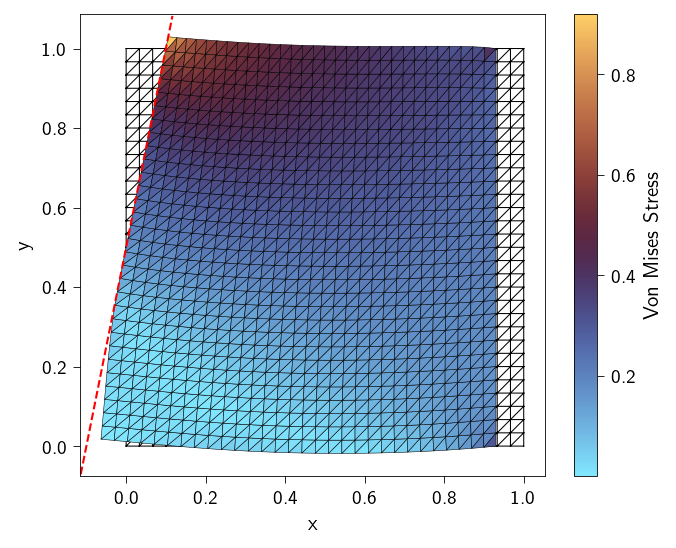

In [23]:
from matplotlib.pyplot import xlabel
from femsolver.plotting import STYLE_PATH
from matplotlib.axes import Axes

plt.style.use(STYLE_PATH)


def plot_displacement_and_stress(
    ax: Axes, u: Array, mesh: Mesh, stress: Array, scale=1.0
) -> None:
    coords, elements = mesh.coords, mesh.elements
    displaced = coords + scale * u

    ax.triplot(
        coords[:, 0],
        coords[:, 1],
        elements,
        color="black",
        linewidth=0.5,
    )
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(cb, label="Von Mises Stress")
    ax.set(xlabel="x", ylabel="y")
    ax.axis("equal")

    # Plot the gap=0 contour (the contact surface)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    pts = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    G = gap(pts).reshape(X.shape)
    ax.contour(X, Y, G, levels=[0], colors="red", linewidths=1, linestyles="--")


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

plot_displacement_and_stress(ax, u.u, mesh, stress_vm)